In [63]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [64]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [65]:
X_train_full = np.load('train_data.npy')
y_train_full = np.load('train_labels.npy')
X_test = np.load('test_data.npy')

In [66]:
img_size = int(np.sqrt(X_train_full.shape[1] // 3))
channels = 3
X_train_full = X_train_full.reshape(-1, img_size, img_size, channels)
X_test = X_test.reshape(-1, img_size, img_size, channels)

#normalize the values
X_train_full = X_train_full/255
X_test = X_test/255

X_train, X_val, y_train, y_val = train_test_split(X_train_full,y_train_full,test_size=0.2)


In [71]:
activation = 'relu'
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation=activation,
                           kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                           input_shape=(img_size, img_size, 3)),

    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation=activation,
                           kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)),

    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation=activation,
                          kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)),

    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(len(np.unique(y_train)),activation = 'softmax')
])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

tf.debugging.set_log_device_placement(True)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

with tf.device('/GPU:0'):
  history = model.fit(X_train,y_train,epochs = 20, validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.1453 - loss: 4.9745 - val_accuracy: 0.2560 - val_loss: 2.2691
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2484 - loss: 2.3139 - val_accuracy: 0.3055 - val_loss: 2.1924
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2804 - loss: 2.2186 - val_accuracy: 0.3205 - val_loss: 2.1257
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3018 - loss: 2.1785 - val_accuracy: 0.3500 - val_loss: 2.0545
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3050 - loss: 2.1596 - val_accuracy: 0.3580 - val_loss: 2.0443
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3152 - loss: 2.1521 - val_accuracy: 0.3415 - val_loss: 2.0453
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3130 - loss: 2.1312 - val_accuracy: 0.3475 - val_loss: 2.0229
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3268 - loss: 2.0977 - val_accuracy: 0.

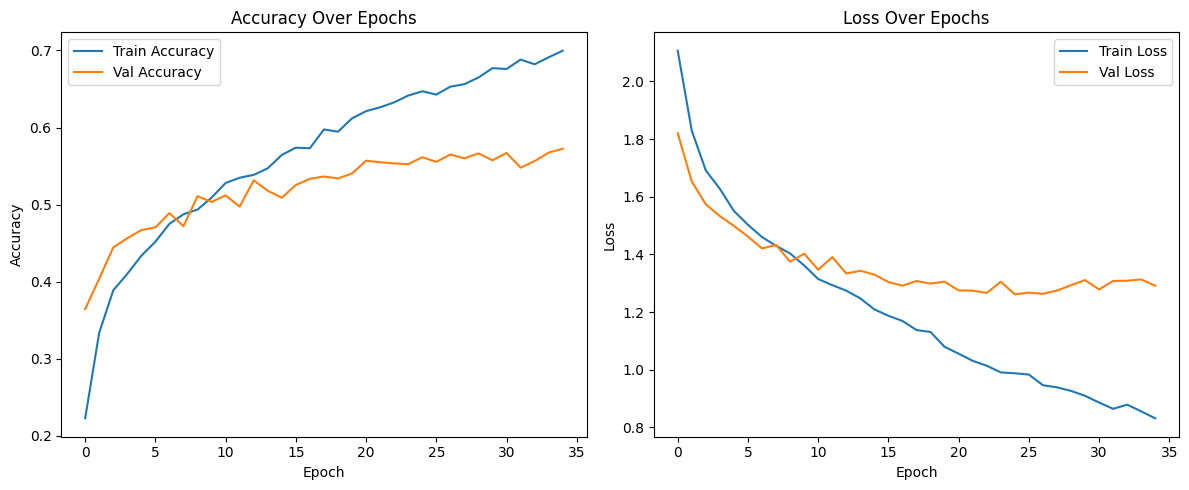

In [59]:

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()